In [145]:
import numpy as np
import pandas as pd
import scipy.stats as st

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import SubplotSpec


In [151]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

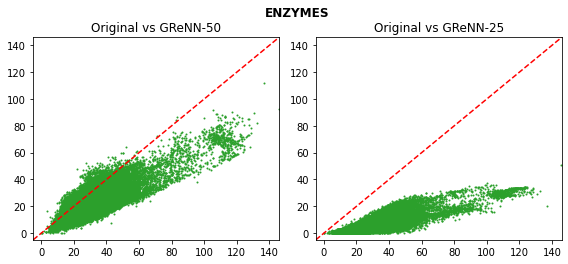

In [162]:
datasets = [
    # ('mutagenicity', '1841'),
            # ('NCI1', '1841'),
            # ('proteins', '1841'),
            ('enzymes', '1841'),
            # ('dd', '255'),
]

percentage_graph = ['50', '25']  # ['50', '25']


rows, cols = len(datasets), len(percentage_graph)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))


grid = plt.GridSpec(rows, cols)

for (idx, (dataset, seed)), axes in zip(enumerate(datasets), [axs, None]):
    folder = f'../results/knn/{dataset}'
    
    dist_100 = np.load(f'{folder}/save_matrix_dist_100/distances/ged_dist_{seed}.npy')
    dist_100.flatten()
    max_100 = round(np.amax(dist_100))

    x = dist_100
        
    # dataset = dataset[0].capitalize() + dataset[1:]
    dataset = dataset.upper()
    
    title = f'{dataset}'
    create_subtitle(fig, grid[idx, ::], title)
    
    for percentage, ax in zip(percentage_graph, axes):
       
        dist_comparison = np.load(f'{folder}/save_matrix_dist_{percentage}/distances/ged_dist_{seed}.npy')
        dist_comparison.flatten()
        max_comparison = round(np.amax(dist_comparison))
    
        ax.set_title(f'Original vs GReNN-{percentage}')

        y = dist_comparison
        
        ax.scatter(x.flatten(), y.flatten(), s=1, color='tab:green')
    
        transform = ax.transAxes
        line = mlines.Line2D([0, 1], [0, 1], color='red', linestyle='--')
        line.set_transform(transform)
        ax.add_line(line)
    
        ax.set(xlim=(-5, max(max_100, max_comparison)),
               ylim=(-5, max(max_100, max_comparison)))

# fig.suptitle(f'Comparison of GEDs between original and reduced graphs', fontsize=20)
fig.tight_layout()
fig.savefig(f'./scatter_all.png') #, format="pdf", bbox_inches="tight")

100
mean-intra 32.696895992897055
mean-inter 33.58048046893951
median-intra 30.950000000000017
median-extra 31.90000000000002
50
mean-intra 22.742999300801003
mean-inter 23.412331884775835
median-intra 20.891385090811042
median-extra 21.761375213714324
25
mean-intra 7.4268441332171165
mean-inter 7.782498957220962
median-intra 6.275773056955717
median-extra 6.56754903597352


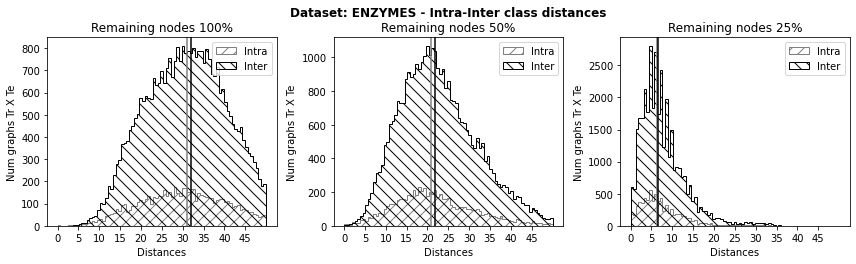

In [163]:
from xmltodict import parse
from itertools import product

percentage_graph = ['100', '50', '25']
labels_graph = ['100', '50', '25_freeze']
analysis = ['intra', 'extra']

cols = len(percentage_graph)
rows= len(datasets) #*2

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*4, 4*rows))

grid = plt.GridSpec(rows, cols)


def load_labels(filename):
    with open(filename, 'r') as file:
        data = "".join(file.readlines())
        
    parsed_data = parse(data)
    
    lbls = np.array([int(graph['@class'])
                     for graph in parsed_data['GraphCollection']['fingerprints']['print']])
    return lbls


def compute_dist_per_class(distances, lbls_train, lbls_test, class_, analy):
    mask_x = lbls_train == class_
    
    if analy == 'intra':
        mask_y = lbls_test == class_
    elif analy == 'extra':
        mask_y = lbls_test != class_
        
    dist_per_class = distances[mask_x,:][:,mask_y]
    
    return dist_per_class


for idx, (dataset, seed) in enumerate(datasets):
    
#     if dataset != 'enzymes':
#         continue
    
    axes = axs #[idx]
    folder = f'../results/knn/{dataset}'
    labels = f'../results/labels/{dataset.upper()}'

    title = f'Dataset: {dataset.upper()} - Intra-Inter class distances'
    create_subtitle(fig, grid[idx, ::], title)
    
    dist_per_percentage = {}
    for an in analysis:
        dist_per_percentage[an] = {}
        
        for percentage, lbl in zip(percentage_graph, labels_graph):
            distances = np.load(f'{folder}/save_matrix_dist_{percentage}/distances/ged_dist_{seed}.npy')
            lbls_train_file = f'{labels}/{lbl}/{seed}/data/train.cxl'
            lbls_test_file = f'{labels}/{lbl}/{seed}/data/test.cxl'

            lbls_train = load_labels(lbls_train_file)
            lbls_test = load_labels(lbls_test_file)
            classes = set(lbls_train).union(set(lbls_test))

            dists = []
            for class_ in classes:
                dist_per_class = compute_dist_per_class(distances, lbls_train, lbls_test, class_, an)


                sum_intra_class = np.mean(dist_per_class)
                # print(f'class {class_}')
                # print(sum_intra_class)
                dists.append(dist_per_class.flatten())#np.sum(dist_per_class, axis=1))

                # print(dist_per_class.size)
            dist_per_percentage[an][percentage] = dists
    
    # print(dist_per_percentage)
    # min_dist = min(np.max(arr) for dists in dist_per_percentage for arr in dists)
    
    
    
    for ax, percentage in zip(axes, percentage_graph):
        dist_intra = np.concatenate(dist_per_percentage['intra'][percentage], axis=0)
        dist_extra = np.concatenate(dist_per_percentage['extra'][percentage], axis=0)
    # if dataset != 'enzymes':
        # if an == 'intra':
        #     colors = ['C0'] #, 'C1'] if dataset != 'enzymes' else [f'C{num}' for num in range(0, 6)]
        # else:
        #     colors = ['C2'] #, 'C3'] if dataset != 'enzymes' else [f'C{num}' for num in range(6, 12)]
        
        # ax.hist([dist_intra, dist_extra], bins=100,  histtype='step',
        #         label=['Intra', 'Inter'], fill=True, alpha=0.2,  range=(0, 400))
        width = 50
        h, edges = np.histogram(dist_intra, bins=np.linspace(0, width, 80))
        ax.stairs(h, edges, label='Intra', hatch='//', color='grey')
        h, edges = np.histogram(dist_extra, bins=np.linspace(0, width, 80))
        ax.stairs(h, edges, label='Inter', hatch='\\\\', color='black')
        #fill=True, alpha=0.2,
        ax.axvline(x=np.median(dist_intra), color='grey', linestyle='-')
        ax.axvline(x=np.median(dist_extra), color='black', linestyle='-')
        ax.set_xticks(range(0, width, 5))
        ax.legend()
        ax.set_title(f'Remaining nodes {percentage}%')
        ax.set_xlabel('Distances')
        ax.set_ylabel('Num graphs Tr X Te')
        
        merged_dist = np.concatenate(dists, axis=0)
        print(percentage)
        print(f'mean-intra', np.mean(dist_intra))
        print(f'mean-inter', np.mean(dist_extra))
        print(f'median-intra', np.median(dist_intra))
        print(f'median-extra', np.median(dist_extra))
    # axes.set_color_cycle(['kbkykrkg'])

#     print(diffs)
fig.tight_layout()
fig.savefig(f'./num_graph_per_dist_.pdf')
    # break
    # x = dist_100

FileNotFoundError: [Errno 2] No such file or directory: './AIDS/distances/pagerank_dist_1.0.npy'

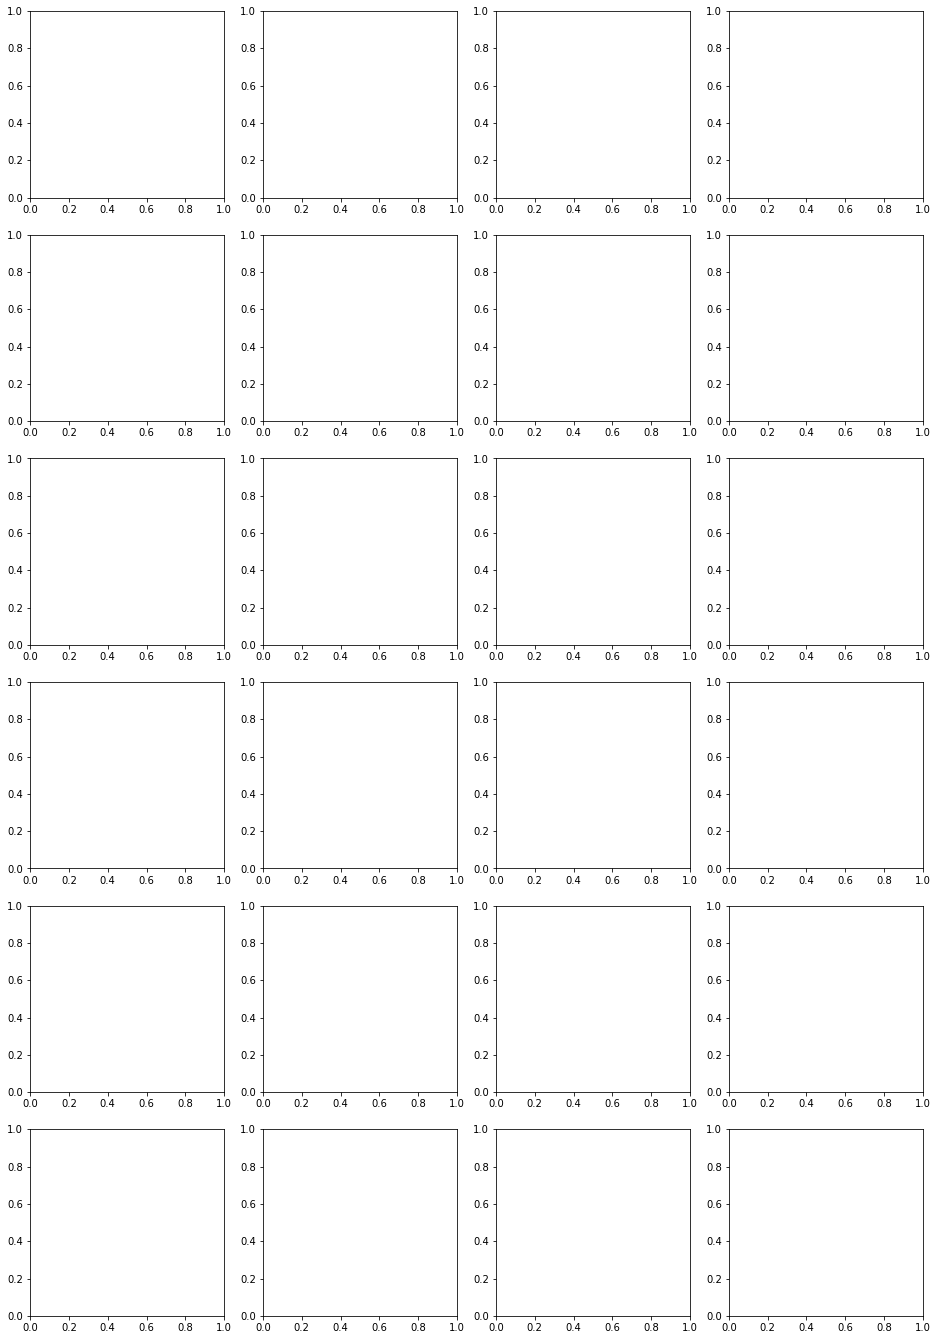

In [157]:
datasets = ['AIDS', 'mutagenicity', 'NCI1', 'proteins_tu', 'enzymes', 'IMDB_binary']
centrality_measure = 'pagerank'
lambdas = ['0.8', '0.6', '0.4', '0.2']


rows, cols = len(datasets), len(lambdas)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4*rows))

grid = plt.GridSpec(rows, cols)

for ((idx, dataset), axes) in zip(enumerate(datasets), axs):
    folder = f'./{dataset}/distances'
    
    dist_100 = np.load(f'{folder}/{centrality_measure}_dist_1.0.npy')
    dist_100.flatten()
    max_100 = round(np.amax(dist_100))

    x = dist_100
    
    title = f'{dataset} - Comparison of GEDs between original and reduced graphs'
    create_subtitle(fig, grid[idx, ::], title)
    print(title)
    
    for lambda_, ax in zip(lambdas, axes):
       
        dist_comparison = np.load(f'{folder}/{centrality_measure}_dist_{lambda_}.npy')
        dist_comparison.flatten()
        max_comparison = round(np.amax(dist_comparison))
        
        
        ax_title = f'1.0 vs {lambda_}'
        ax.set_title(ax_title)

        y = dist_comparison
        
        print(f'lambda: {lambda_}')

        counter = 0
        max_val = float('-inf')
        diffs = []
        for idx, (x_row, y_row) in enumerate(zip(x, y)):
            for idx_col, (x_v, y_v) in enumerate(zip(x_row, y_row)):
                
                diff_val = y_v - x_v
                if diff_val > 0:
                    diffs.append(diff_val)
                    
                if diff_val > max_val and diff_val > 0:
                    max_val = diff_val
#                     print('#####')
#                     print(max_val)
#                     print(idx, idx_col, x_v, y_v)
                if x_v < y_v:
#                 print(idx, x_v, y_v)
                    counter += 1
    
        print(counter, len(x.flatten()), round(100 * counter / len(x.flatten()), 2))
        ax.hist(diffs, bins=100)
#     print(diffs)
fig.tight_layout()

In [ ]:
datasets = ['AIDS', 'mutagenicity', 'NCI1', 'proteins_tu', 'enzymes', 'IMDB_binary']
centrality_measure = 'pagerank'
lambdas = ['0.8', '0.6', '0.4', '0.2']


rows, cols = len(datasets), len(lambdas)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4*rows))

grid = plt.GridSpec(rows, cols)

for ((idx, dataset), axes) in zip(enumerate(datasets), axs):
    folder = f'./{dataset}/distances'
    
    dist_100 = np.load(f'{folder}/{centrality_measure}_dist_1.0.npy')
    dist_100.flatten()
    max_100 = round(np.amax(dist_100))

    x = dist_100
    
    title = f'{dataset} - Comparison of GEDs between original and reduced graphs'
    create_subtitle(fig, grid[idx, ::], title)
    print(title)
    
    for lambda_, ax in zip(lambdas, axes):
       
        dist_comparison = np.load(f'{folder}/{centrality_measure}_dist_{lambda_}.npy')
        dist_comparison.flatten()
        max_comparison = round(np.amax(dist_comparison))
        
        
        ax_title = f'1.0 vs {lambda_}'
        ax.set_title(ax_title)

        y = dist_comparison
        
#         print(f'lambda: {lambda_}')

        counter = 0
        max_val = float('-inf')
        diffs = []
        for idx, (x_row, y_row) in enumerate(zip(x, y)):
            for idx_col, (x_v, y_v) in enumerate(zip(x_row, y_row)):
                
                diff_val = y_v - x_v
                if diff_val > 0:
                    diffs.append(x_v)
                    
                if x_v < y_v:
                    counter += 1
    
#         print(counter, len(x.flatten()), round(100 * counter / len(x.flatten()), 2))
        ax.hist(diffs, bins=100)
#     print(diffs)
fig.tight_layout()

In [94]:
datasets = ['AIDS', 'mutagenicity', 'NCI1', 'proteins_tu', 'enzymes', 'IMDB_binary']

confidence = 0.95

for dataset in datasets:
    filename = f'./{dataset}/time.csv'
    
    df = pd.read_csv(filename)
    df.drop(columns=df.columns[0],
           axis=1,
           inplace=True)
#     df = df.iloc[:, ::-1]
    
    
    head = [float(val) for val in df.head(0).columns]
#     print(head)
    
    computation_times = np.array(df.values)
    num_samples, _ = computation_times.shape
    
    computation_times_AVERAGE = np.average(computation_times, axis=0)
    computation_times_STDEV = np.std(computation_times, axis=0, ddof=1)
    coeff = st.t.ppf((1 + confidence) / 2., num_samples-1)
    
    computation_times_CONF_INT = coeff * computation_times_STDEV / np.sqrt(num_samples)

# #     print(df)
#     print(computation_times_AVERAGE)
#     print(computation_times_STDEV)
#     print(computation_times_CONF_INT)
#     fig, ax = plt.subplots()
#     x = head
#     y = computation_times_AVERAGE
#     y_err = computation_times_CONF_INT
    
#     ax.plot(head, computation_times_AVERAGE, '-')
#     ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)
#     ax.plot(x, y, 'o', color='tab:blue')
    if dataset == 'proteins_tu':
        dataset = 'proteins'
    elif dataset == 'IMDB_binary':
        dataset = 'IMDB Binary'
        
    dataset = dataset[0].capitalize() + dataset[1:]
    sep = '$\pm$'
    print(f'& {dataset} & {" & ".join([str(round(mean, 2)) + sep + str(round(conf, 2)) for mean, conf in zip(computation_times_AVERAGE, computation_times_CONF_INT)])} \\\\')
#     print('########################')

    

& AIDS & 9.93$\pm$0.25 & 7.25$\pm$0.3 & 5.59$\pm$0.13 & 4.0$\pm$0.13 & 2.78$\pm$0.21 \\
& Mutagenicity & 63.27$\pm$1.62 & 46.08$\pm$1.55 & 33.23$\pm$0.95 & 21.91$\pm$0.55 & 15.18$\pm$0.72 \\
& NCI1 & 51.41$\pm$1.1 & 36.72$\pm$0.95 & 25.85$\pm$0.71 & 17.89$\pm$0.68 & 12.62$\pm$0.88 \\
& Proteins & 7.09$\pm$0.37 & 4.67$\pm$0.25 & 3.09$\pm$0.16 & 2.02$\pm$0.21 & 1.18$\pm$0.24 \\
& Enzymes & 2.18$\pm$0.1 & 1.41$\pm$0.1 & 1.11$\pm$0.14 & 0.61$\pm$0.04 & 0.35$\pm$0.05 \\
& IMDB Binary & 4.32$\pm$0.15 & 2.91$\pm$0.23 & 1.94$\pm$0.21 & 1.08$\pm$0.13 & 0.61$\pm$0.11 \\


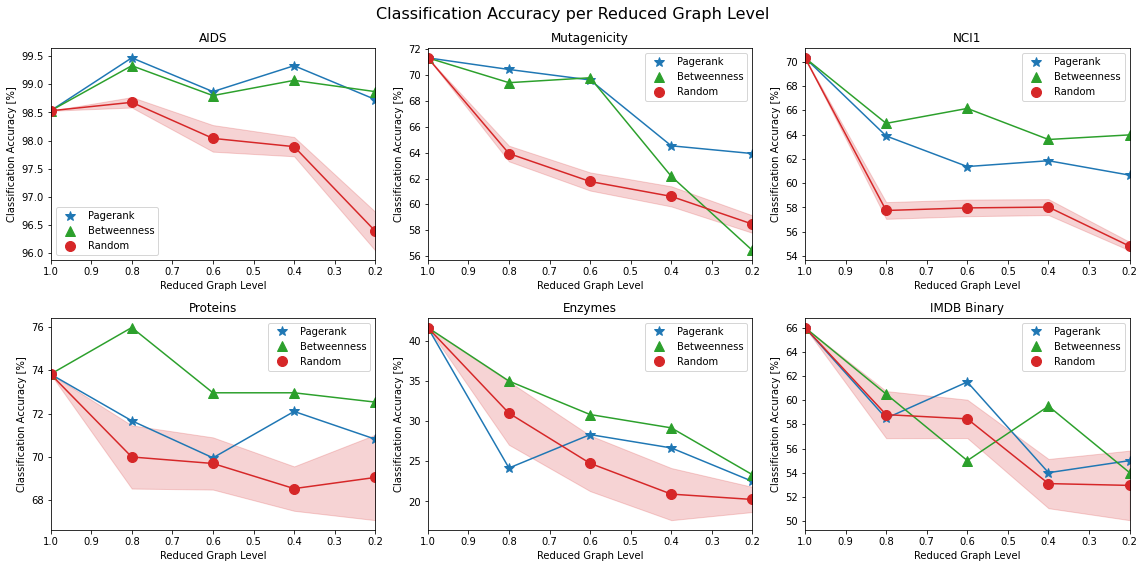

In [102]:
datasets = ['AIDS', 'mutagenicity', 'NCI1', 'proteins_tu', 'enzymes', 'IMDB_binary']
raw_data = [
        [[98.53, 99.47, 98.87, 99.33, 98.73], [98.53, 99.33, 98.8,  99.07, 98.87]],
        [[71.33, 70.43, 69.62, 64.53, 63.93], [71.33, 69.41, 69.79, 62.17, 56.44]],
        [[70.33, 63.89, 61.37, 61.85, 60.66], [70.33, 64.93, 66.16, 63.6,  63.98]],
        [[73.82, 71.67, 69.96, 72.1,  70.82], [73.82, 75.97, 72.96, 72.96, 72.53]],
        [[41.67, 24.17, 28.33, 26.67, 22.5 ], [41.67, 35.,   30.83, 29.17, 23.33]],
        [[66,    58.5,  61.5,  54.,   55.  ], [66,    60.5,  55,    59.5,  54.  ]]
       ]
centrality_measures = ['Pagerank', 'Betweenness', 'Random']

confidence = 0.95

rows, cols = 2, 3

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4*rows))

grid = plt.GridSpec(rows, cols)


for idx, (dataset, data, axes) in enumerate(zip(datasets, raw_data, axs.flatten())):
    pagerank_data, betweenness_data = data
    acc_full_graph = pagerank_data[0]
    
    filename = f'./{dataset}/random_values.csv'
    
    df = pd.read_csv(filename)
    df.drop(columns=df.columns[0],
           axis=1,
           inplace=True)

    df.insert(loc=0, column=1.0, value=[acc_full_graph for _ in range(len(df.index))])
    head = [float(val) for val in df.head(0).columns]

    
    random_acc = np.array(df.values)
    num_samples, _ = random_acc.shape
    
    random_acc_AVERAGE = np.average(random_acc, axis=0)
    random_acc_STDEV = np.std(random_acc, axis=0, ddof=1)
    coeff = st.t.ppf((1 + confidence) / 2., num_samples-1)
    
    random_acc_CONF_INT = coeff * random_acc_STDEV / np.sqrt(num_samples)
    
#     title = dataset
#     create_subtitle(fig, grid[idx, ::], title)

#     print(random_acc_CONF_INT)
#     fig, ax = plt.subplots()
    title = f'{dataset} - Classification Accuracy per Reduced Graph Space'
    
    if dataset == 'proteins_tu':
        dataset = 'proteins'
    elif dataset == 'IMDB_binary':
        dataset = 'IMDB Binary'
        
    dataset = dataset[0].capitalize() + dataset[1:]
    
    axes.set_title(dataset)
    axes.set_xlim(1.0, 0.2)
    axes.set_ylabel('Classification Accuracy [%]')
    axes.set_xlabel('Reduced Graph Level')
    x = head
    y = random_acc_AVERAGE
    y_err = random_acc_CONF_INT
    
    
    axes.plot(x, pagerank_data, '-', color='tab:blue')
    axes.plot(x, pagerank_data, '*', color='tab:blue', markersize=10, label='Pagerank')
    
    axes.plot(x, betweenness_data, '-', color='tab:green')
    axes.plot(x, betweenness_data, '^', color='tab:green', markersize=10, label='Betweenness')
    
    axes.plot(head, random_acc_AVERAGE, '-', color='tab:red')
    axes.fill_between(x, y - y_err, y + y_err, alpha=0.2,color='tab:red')
    axes.plot(x, y, 'o', color='tab:red', markersize=10, label='Random')
    
    axes.legend()


fig.suptitle('Classification Accuracy per Reduced Graph Level', fontsize=16)
fig.tight_layout()
fig.savefig(f'./accuracies.png')